In [35]:
#DATASET LINK
#https://github.com/megagonlabs/HappyDB

In [36]:
#LIBRARY 
import numpy as np 
import pandas as pd
import gensim
import os
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/cleaned_hm.csv")
data.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [39]:
#Do categories wise value count 
data['predicted_category'].value_counts()

affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64

In [40]:
# deleting happy moments with more than 10 sentences
mod_data = data.loc[data['num_sentence'] <= 10]
mod_data["predicted_category"].value_counts()

affection           34020
achievement         33966
enjoy_the_moment    11115
bonding             10700
leisure              7458
nature               1839
exercise             1202
Name: predicted_category, dtype: int64

In [41]:

## categorical to numerical
encode = {
    "affection" : 0,
    "achievement"  : 1,       
    "bonding" : 2,    
    "enjoy_the_moment" : 3,     
    "leisure"  : 4,    
    "nature" : 5,    
    "exercise" : 6
}
mod_data["predicted_category"] = mod_data["predicted_category"].apply(lambda x: encode[x])
mod_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,0
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,0
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,6
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,2
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,0


In [42]:
#text cleaning for NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import re
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
def clean_text(df):
    all_reviews = list()
    lines = df["cleaned_hm"].values.tolist()
    for text in lines:
        text = text.lower()
        text = re.sub('[^a-zA-Z]', ' ', text)
        words=nltk.word_tokenize(text)
        stop_words= set(stopwords.words('english'))
        stop_words.discard("not")
        words_without_stop_words=[word for word in words if word not in stop_words]
        #words=[lemmatizer.lemmatize(word) for word in words_without_stop_words ]
        #words=[ps.stem(word) for word in words_without_stop_words ]
        #words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews
happy_lines = clean_text(mod_data)
happy_lines[0:5]  

[['i',
  'went',
  'on',
  'a',
  'successful',
  'date',
  'with',
  'someone',
  'i',
  'felt',
  'sympathy',
  'and',
  'connection',
  'with'],
 ['i',
  'was',
  'happy',
  'when',
  'my',
  'son',
  'got',
  'marks',
  'in',
  'his',
  'examination'],
 ['i', 'went', 'to', 'the', 'gym', 'this', 'morning', 'and', 'did', 'yoga'],
 ['we',
  'had',
  'a',
  'serious',
  'talk',
  'with',
  'some',
  'friends',
  'of',
  'ours',
  'who',
  'have',
  'been',
  'flaky',
  'lately',
  'they',
  'understood',
  'and',
  'we',
  'had',
  'a',
  'good',
  'evening',
  'hanging',
  'out'],
 ['i',
  'went',
  'with',
  'grandchildren',
  'to',
  'butterfly',
  'display',
  'at',
  'crohn',
  'conservatory']]

In [44]:
#number of words in each review/ happymoments/sentence=55
validation_split = 0.2
max_length = 55
#tokenize te sentences and represent them in numbers other way is to todo one hot 
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(happy_lines)
sequences = tokenizer_obj.texts_to_sequences(happy_lines)
word_index = tokenizer_obj.word_index
print("unique tokens - "+str(len(word_index)))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab_size - '+str(vocab_size))
lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')

unique tokens - 23773
vocab_size - 23774


In [45]:
X=lines_pad
y=pd.get_dummies(mod_data['predicted_category']).values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print('Shape of X_train_pad:', X_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (80240, 55)
Shape of y_train: (80240, 7)
Shape of X_test_pad: (20060, 55)
Shape of y_test: (20060, 7)


In [46]:
import gensim
model = gensim.models.Word2Vec(sentences=happy_lines, size=100, window=5, workers=4, min_count=1, sg=0) #sg= 1:skip-gram 0:cbow
vocab_words = list(model.wv.vocab)                                                                      
print(len(vocab_words))

23773


In [47]:
#hyper meter  
# size: The number of dimensions of the embeddings and the default is 100.
# window: The maximum distance between a target word and words around the target word. The default window is 5.
# min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
# workers: The number of partitions during training and the default workers is 3.
# sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [48]:
#save wordvectors
filename = "/content/drive/My Drive/Colab Notebooks/happydb_word2vec_full.txt"
model.wv.save_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [49]:
#read and create embedding matrix
embedding_index = {}
f = open(os.path.join('', '/content/drive/My Drive/Colab Notebooks/happydb_word2vec_full.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coeff = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coeff
f.close()

In [51]:
embedding_dim=100
#make a  matrix of zeros with rows = numner of words and columns =300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
#if the word is not present in model that we have impoeted then that word vector will be replaced in
#embedding matrix otherwise it will remain 0 as we have defined 
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [52]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

In [53]:
# define model
model_own = Sequential()
model_own.add(embedding_layer)
model_own.add(LSTM(units=32,  dropout=0.2, recurrent_dropout=0.25))
model_own.add(Dense(7, activation='softmax'))

model_own.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_own.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 55, 100)           2377400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 231       
Total params: 2,394,655
Trainable params: 17,255
Non-trainable params: 2,377,400
_________________________________________________________________
None


In [54]:
history_word2vec = model_own.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Train on 80240 samples, validate on 20060 samples
Epoch 1/10
80240/80240 [==============================] - 46s 575us/step - loss: 1.2107 - accuracy: 0.5628 - val_loss: 0.8698 - val_accuracy: 0.7215
Epoch 2/10
80240/80240 [==============================] - 46s 568us/step - loss: 0.7499 - accuracy: 0.7511 - val_loss: 0.5430 - val_accuracy: 0.8212
Epoch 3/10
80240/80240 [==============================] - 46s 572us/step - loss: 0.5459 - accuracy: 0.8170 - val_loss: 0.4692 - val_accuracy: 0.8397
Epoch 4/10
80240/80240 [==============================] - 46s 574us/step - loss: 0.4889 - accuracy: 0.8325 - val_loss: 0.4258 - val_accuracy: 0.8490
Epoch 5/10
80240/80240 [==============================] - 46s 570us/step - loss: 0.4540 - accuracy: 0.8393 - val_loss: 0.4009 - val_accuracy: 0.8558
Epoch 6/10
80240/80240 [==============================] - 46s 575us/step - loss: 0.4295 - accuracy: 0.8467 - val_loss: 0.3770 - val_accuracy: 0.8631
Epoch 7/10
80240/80240 [==============================] 

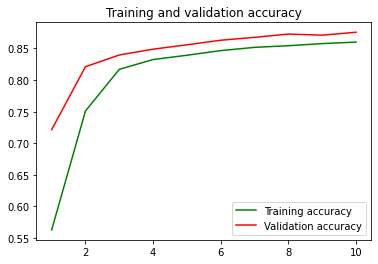

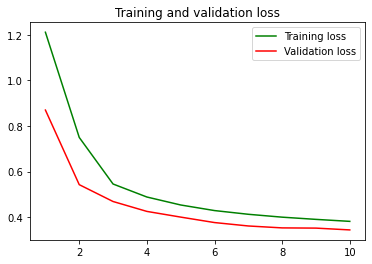

In [55]:
# Plot results
import matplotlib.pyplot as plt

acc = history_word2vec.history['accuracy']
val_acc = history_word2vec.history['val_accuracy']
loss = history_word2vec.history['loss']
val_loss = history_word2vec.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [56]:
accr = model_own.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

20060/20060 [==============================] - 4s 222us/step
Test set
  Loss: 0.345
  Accuracy: 0.876


In [58]:
#TEST With a new emotion for classification 
max_length = 55 #this is already defined on top
new_emotion = ['I went to the gym this morning and did yoga ']
seq = tokenizer_obj.texts_to_sequences(new_emotion)
padded = pad_sequences(seq, maxlen=max_length)
pred = model_own.predict(padded)
labels = ['affection','achievement','enjoy_the_moment','bonding','leisure','nature','exercise']
print(pred, labels[np.argmax(pred)])

[[0.00322948 0.06620643 0.00280707 0.01825686 0.05572937 0.00419144
  0.84957933]] exercise
